In [1]:
# Referencing https://github.com/zcaceres/spec_augment

In [2]:
from collections import namedtuple
import random
import torch
import torchaudio
from torchaudio import transforms
import sys, os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
sys.path.append(os.path.abspath('..'))
from augmentations.spec_augment import SpecAugment
import signal_utils as sig
from scipy.io import wavfile

## Convert WAV to Mel Spectrogram

In [3]:
def tensor_to_img(spectrogram):
    plt.figure(figsize=(14,1))
    plt.imshow(spectrogram[0])
    plt.show()
    display(spectrogram.shape)

In [4]:
class SpectrogramToDB(object):
    """Turns a spectrogram from the power/amplitude scale to the decibel scale.
    This output depends on the maximum value in the input spectrogram, and so
    may return different values for an audio clip split into snippets vs. a
    a full clip. This method is sourced from an earlier release of torchaudio and
    is no longer present in current versions.
    Args:
        stype (str): scale of input spectrogram ("power" or "magnitude").  The
            power being the elementwise square of the magnitude. default: "power"
        top_db (float, optional): minimum negative cut-off in decibels.  A reasonable number
            is 80.
    """
    def __init__(self, stype="power", top_db=None):
        self.stype = stype
        if top_db is not None and top_db < 0:
            raise ValueError('top_db must be positive value')
        self.top_db = top_db
        self.multiplier = 10. if stype == "power" else 20.
        self.amin = 1e-10
        self.ref_value = 1.
        self.db_multiplier = np.log10(np.maximum(self.amin, self.ref_value))

    def __call__(self, spec):
        # numerically stable implementation from librosa
        # https://librosa.github.io/librosa/_modules/librosa/core/spectrum.html
        spec_db = self.multiplier * torch.log10(torch.clamp(spec, min=self.amin))
        spec_db -= self.multiplier * self.db_multiplier

        if self.top_db is not None:
            spec_db = torch.max(spec_db, spec_db.new_full((1,), spec_db.max() - self.top_db))
        return spec_db

In [5]:
def tfm_spectro(ad:Audio, sr=16000, to_db_scale=False, n_fft=1024, 
                ws=None, hop=None, f_min=0.0, f_max=-80, pad=0, n_mels=128):
    # We must reshape signal for torchaudio to generate the spectrogram.
    mel = transforms.MelSpectrogram(sample_rate=ad.sr, n_mels=n_mels, n_fft=n_fft, win_length=ws, hop_length=hop, 
                                    f_min=f_min, f_max=f_max, pad=pad,)(ad.sig.reshape(1, -1))
    if to_db_scale: mel = SpectrogramToDB(stype='magnitude', top_db=f_max)(mel)
    return mel

### With SciPy and Signal Utils

16000
[ 76  66  88 ... 293 375 535]
(177921,)

Preprocessing...
[[-0.40694317  7.0348535   2.1057363  ... -0.55941325 -0.7967041
  -0.7086164 ]
 [ 1.0484523   5.36495     0.2964804  ... -1.1358768  -0.11702261
  -0.3640729 ]
 [-1.6136645   1.5802869  -0.05510565 ... -1.5191518  -0.7268665
  -1.5202956 ]
 ...
 [ 0.6520298   0.2506088   0.40305197 ... -1.1990806  -1.1001885
  -1.531797  ]
 [-1.6136645   1.5802869  -0.05510565 ... -1.5191518  -0.7268665
  -1.5202956 ]
 [ 1.0484523   5.36495     0.2964804  ... -1.1358768  -0.11702261
  -0.3640729 ]]
(512, 300)
torch.Size([512, 300, 1])



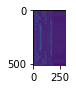

torch.Size([1, 512, 300])

In [7]:
sr, audio=wavfile.read("../test.wav")
print(sr)
print(audio)
print(audio.shape)
print()
print("Preprocessing...")
start=np.random.randint(0,audio.shape[0]-48320+1)
audio=audio[start:start+48320]
audio=sig.preprocess(audio).astype(np.float32)
print(audio)
print(audio.shape)
audio = torch.tensor(np.expand_dims(audio, 2))
print(audio.shape)
#audio = torch.reshape(torch.tensor(audio), (1, -1))
print()
specAugment = SpecAugment(W=40, F=40, T=50, freq_masks=3, time_masks=3, freq_zero=True, time_zero=True, to_mel=False)
aug = specAugment(audio)
tensor_to_img(aug)

16000
[ 76  66  88 ... 293 375 535]
(177921,)

Preprocessing...
[[-1.2034309   0.06534488 -1.1197337  ... -0.36736074 -0.23910347
   0.4178095 ]
 [-0.38622415 -0.79019713  0.33236393 ... -1.0960857  -0.50014573
   0.8370429 ]
 [-0.23233375 -0.00872439  1.8114481  ... -0.88378847 -0.78115517
  -0.16769063]
 ...
 [-0.16805227  0.9726431   2.0995836  ... -0.75589013 -0.8477854
  -1.0929698 ]
 [-0.23233375 -0.00872439  1.8114481  ... -0.88378847 -0.78115517
  -0.16769063]
 [-0.38622415 -0.79019713  0.33236393 ... -1.0960857  -0.50014573
   0.8370429 ]]
(512, 300)
(512, 300, 1)
tensor([[-1.2034,  0.0653, -1.1197,  ..., -1.0961, -0.5001,  0.8370]])
torch.Size([1, 153600])

Converting to mel spectrogram


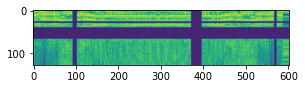

torch.Size([1, 128, 601])

In [15]:
sr, audio=wavfile.read("../test.wav")
print(sr)
print(audio)
print(audio.shape)
print()
print("Preprocessing...")
start=np.random.randint(0,audio.shape[0]-48320+1)
audio=audio[start:start+48320]
audio=sig.preprocess(audio).astype(np.float32)
print(audio)
print(audio.shape)
audio = np.expand_dims(audio, 2)
print(audio.shape)
audio = torch.reshape(torch.tensor(audio), (1, -1))
print(audio)
print(audio.shape)
print()
print("Converting to mel spectrogram")
specAugment = SpecAugment(W=40, F=40, T=50, freq_masks=3, time_masks=3, freq_zero=True, time_zero=True, to_mel=True)
aug = specAugment(audio)
tensor_to_img(aug)

### With IPython Audio

In [17]:
AudioData = namedtuple('AudioData', ['sig', 'sr'])

In [12]:
audio = AudioData(*torchaudio.load("../test.wav"))
print(audio)
audio[0].shape

AudioData(sig=tensor([[0.0023, 0.0020, 0.0027,  ..., 0.0089, 0.0114, 0.0163]]), sr=16000)


torch.Size([1, 177921])

In [13]:
spectrogram = tfm_spectro(audio, ws=512, hop=256, n_mels=128, to_db_scale=True, f_max=8000, f_min=-80)
spectrogram.shape

torch.Size([1, 128, 696])

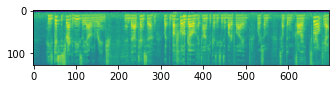

torch.Size([1, 128, 696])

In [14]:
tensor_to_img(spectrogram)

In [15]:
specAugment = SpecAugment()

## Time Warp

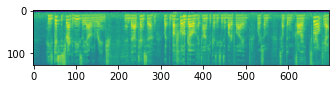

torch.Size([1, 128, 696])

/nethome/sramshetty3/ls/VGGVox-PyTorch/augmentations/spec_augment.py:296: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor((queries - floor), dtype=grid_type, device=grid_device)


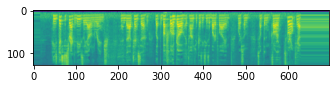

torch.Size([1, 128, 696])

In [10]:
def test_time_warp(spectro):
    tensor_to_img(specAugment.time_warp(spectro))
tensor_to_img(spectrogram)    
test_time_warp(spectrogram)

## Frequency Masking

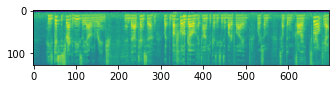

torch.Size([1, 128, 696])

In [11]:
def test_freq_mask(spectro):
    tensor_to_img(specAugment.freq_mask(spectro))
test_freq_mask(spectrogram)

## Time Masking

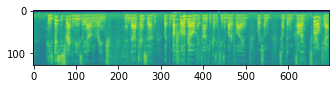

torch.Size([1, 128, 696])

In [12]:
def test_time_mask(spectro):
    tensor_to_img(specAugment.time_mask(spectro))
test_time_mask(spectrogram)

## Full SpecAugment

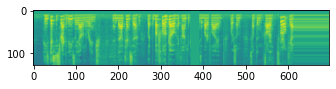

torch.Size([1, 128, 696])

In [13]:
combined = specAugment(spectrogram)
tensor_to_img(combined)

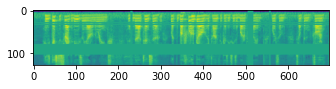

torch.Size([1, 128, 696])

In [16]:
specAugment_masks = SpecAugment(freq_masks=4, time_masks=3)
result = specAugment_masks(spectrogram)
tensor_to_img(result)

/nethome/sramshetty3/ls/VGGVox-PyTorch/augmentations/spec_augment.py:296: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor((queries - floor), dtype=grid_type, device=grid_device)


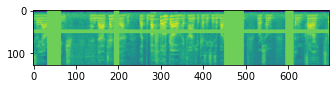

torch.Size([1, 128, 696])

In [17]:
specAugment_zero = SpecAugment(W=50, F=50, T=100, freq_masks=2, time_masks=5, freq_zero=True, time_zero=True)
result = specAugment_zero(spectrogram)
tensor_to_img(result)